In [1]:
%matplotlib inline

from glob import glob
import json
from typing import List

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize

In [2]:
import warnings
warnings.filterwarnings("ignore")

figsize(15, 9)
figsize(15, 9)

sns.__version__

'0.11.2'

In [3]:
def inner_product(row):
    return sum([g * p for g, p in row.items()])

In [4]:
result_files = glob("./results/*.json")

rows = []
for rf in result_files:
    with open(rf, "r") as istream:
        stats = json.load(istream)

    for name, history in stats.items():
        for g in history:
            rows.append({"guesses": g, "strategy": name})

df = pd.DataFrame(rows)

counts = df.assign(count=1).groupby(["strategy", "guesses"])[["count"]].sum().reset_index()
pivot_df = counts.pivot("strategy", "guesses", "count").fillna(0.0)
norm_pivot_df = pivot_df / pivot_df.sum(axis=1).max()
melted_df = norm_pivot_df.reset_index().melt(id_vars=['strategy'], value_name = 'probability')
norm_pivot_df['avg'] = norm_pivot_df.apply(inner_product, axis=1)
norm_pivot_df.sort_values(by='avg')

guesses,1,2,3,4,5,6,7,avg
strategy,,,,,,,,
StrategyMinMaxFeedbackMatches,0.000000,0.011663,0.171814,0.405832,0.265335,0.094060,0.051296,4.412203
StrategyFirstGuessSoare,0.000000,0.015875,0.142333,0.309503,0.266523,0.154752,0.111015,4.734989
StrategyFirstGuessRoate,0.000000,0.016847,0.141253,0.301620,0.276242,0.154860,0.109179,4.738553
StrategyFirstGuessArise,0.000864,0.015551,0.141685,0.302700,0.273110,0.147516,0.118575,4.748488
StrategyFirstGuessRaise,0.000864,0.014363,0.141469,0.297408,0.273650,0.154104,0.118143,4.763499
StrategyFirstGuessSerai,0.000000,0.010151,0.137797,0.312095,0.271490,0.155292,0.113175,4.763499
StrategyMatchedFeedback,0.000108,0.011231,0.110907,0.291469,0.313499,0.171490,0.101296,4.826674
StrategyFirstGuessAdieu,0.000000,0.012095,0.112527,0.293413,0.291793,0.170302,0.119870,4.855292
StrategyFirstGuessAudio,0.000000,0.011339,0.111771,0.292225,0.287581,0.180562,0.116523,4.863823


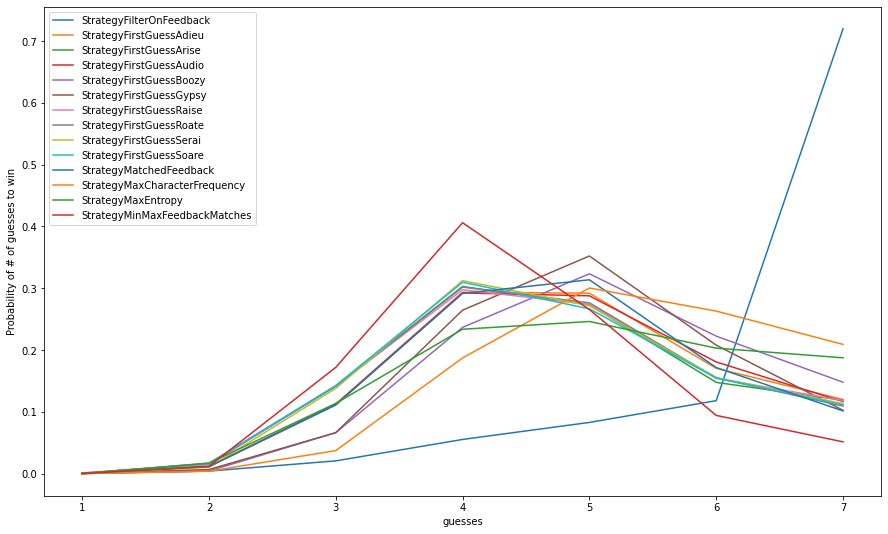

In [5]:
melted_df[
    ~melted_df['strategy'].isin([
        'StrategyRandomWithReplacement',
        'StrategyRandomWithoutReplacement',
#         'StrategyFilterOnFeedback',
    ])
]\
    .set_index("guesses")\
    .groupby('strategy')["probability"]\
    .plot(legend=True)

plt.ylabel("Probability of # of guesses to win")

None

# Analyzing Feedback

In [6]:
from wordle.strategies.feedback_lookup_cache import FeedbackLookupCache
from wordle.util import load_answers, load_non_answers

all_words = sorted(load_answers()+ load_non_answers(), key=lambda w: w.text)
wordset = set([word.text for word in all_words])

flc = FeedbackLookupCache()

# Words with the best initial scores

In [7]:
best_score = float('inf')
best_guesses = []
for guess in all_words:
    score = flc.sizeof_largest_feedback_set(guess, wordset)
    if score < best_score:
        best_score = score
        best_guesses = []
    if score <= best_score:
        best_guesses.append(guess)

In [8]:
len(best_guesses)

1

In [9]:
len(set(w.text for w in best_guesses).intersection(w.text for w in load_answers()))

0

In [10]:
'roate' in [w.text for w in best_guesses]

False

In [11]:
best_guesses

[Word(text='serai')]

In [12]:
best_score

697

# Words with most feedback matches

In [40]:
word_max_feedback_matches = {}
for guess in all_words:
    word_max_feedback_matches[guess.text] = max(len(s) for s in flc.load_feedback(guess.text).values())


max_words, max_score = [], float('-inf')
for word, n_matches in word_max_feedback_matches.items():
    if n_matches > max_score:
        max_score = n_matches
        max_words = []
    
    if n_matches >= max_score:
        max_words.append(word)

max_words, max_score

(['gyppy'], 8189)

# Maximum Entropy

In [52]:
import numpy as np


N_TOTAL_WORDS = len(all_words)
TARGET = N_TOTAL_WORDS / 2
entropy_rows = []
for guess in all_words:
    feedback_dict = flc.load_feedback(guess.text)
    lens = [len(answers) for answers in feedback_dict.values()]
    max_feedback_entropy = abs(TARGET - max(lens))
    avg_feedback_entropy = abs(TARGET - np.average(lens))
    
    entropy_rows.append({
        "guess": guess.text,
        "max_fb_entropy": max_feedback_entropy,
        "avg_fb_entropy": avg_feedback_entropy,
    })

entropy_df = pd.DataFrame(entropy_rows)
entropy_df.sort_values(by="avg_fb_entropy").head()

,guess,max_fb_entropy,avg_fb_entropy
8742,qajaq,933.0,6115.371429
8739,pzazz,195.0,6177.142857
11997,urubu,16.0,6210.000000
713,ayaya,216.0,6215.750000
5508,jeeze,401.0,6221.265306


In [56]:
entropy_df.sort_values(by="max_fb_entropy").head()

,guess,max_fb_entropy,avg_fb_entropy
1323,boozy,2.0,6354.969697
3679,feeze,6.0,6280.095238
5645,jutty,13.0,6321.797468
8449,poppy,14.0,6298.000000
8441,poopy,14.0,6343.450549


In [57]:
entropy_df[entropy_df['guess'].isin(['roate', 'raise', 'arise', 'audio', 'adieu'])]

,guess,max_fb_entropy,avg_fb_entropy
109,adieu,4777.0,6378.793388
533,arise,5604.0,6413.933333
635,audio,4284.0,6394.000000
8859,raise,5604.0,6413.123596
9247,roate,5351.0,6412.711864


50% = 6486.0


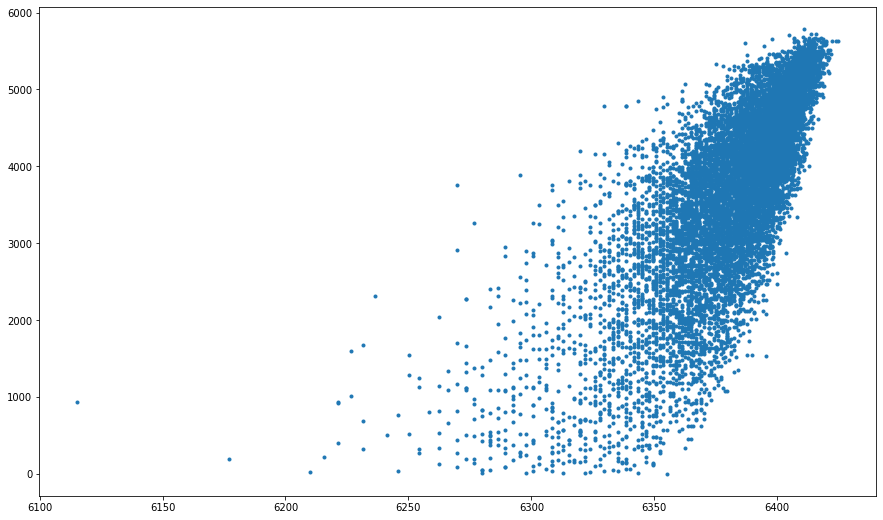

In [55]:
print(f"50% = {TARGET}")
plt.plot(entropy_df["avg_fb_entropy"], entropy_df["max_fb_entropy"], '.')
None

# Max Score

In [68]:
from wordle.types import Feedback

max_score_rows = []
for guess in all_words:
    max_score = float('-inf')
    feedback_dict = flc.load_feedback(guess.text)
    for fb, fb_set in feedback_dict.items():
        n_not_wrong = len([f for f in fb if f is not Feedback.WRONG])
        n_matches = len(fb_set)
        score = n_not_wrong * n_matches
        
        if score > max_score:
            max_score = score
    max_score_rows.append({"name": guess.text, "max_score": max_score})


max_score_df = pd.DataFrame(max_score_rows)
max_score_df.head()

,name,max_score
0,aahed,1635
1,aalii,1424
2,aargh,1263
3,aarti,1287
4,abaca,1978


In [69]:
max_score_df.sort_values(by="max_score", ascending=False)

,name,max_score
4782,gypsy,3768
1518,bubba,3680
1611,busby,3645
1900,check,3525
5254,huzza,3511
...,...,...
1580,bunny,767
4741,gunny,761
8872,rales,757
6096,lares,757


# Weighted Max Score

In [74]:
from wordle.types import Feedback

scores = {
    "C": 3,
    "P": 2,
    "X": 1,
}

wmax_score_rows = []
for guess in all_words:
    max_score = float('-inf')
    feedback_dict = flc.load_feedback(guess.text)
    for fb, fb_set in feedback_dict.items():
        weighted_feedback_score = sum([scores[f] for f in Feedback.to_string(fb)])
        n_matches = len(fb_set)
        score = weighted_feedback_score * n_matches
        
        if score > max_score:
            max_score = score
    wmax_score_rows.append({"name": guess.text, "max_score": max_score})


wmax_score_df = pd.DataFrame(wmax_score_rows)
wmax_score_df.head()

,name,max_score
0,aahed,12715
1,aalii,19450
2,aargh,19775
3,aarti,13045
4,abaca,28275


In [75]:
wmax_score_df.sort_values(by="max_score")

,name,max_score
9800,serai,4182
10364,soare,4614
9801,seral,4734
8967,reais,4739
10786,strae,4872
...,...,...
4147,fuzzy,39375
5276,hyphy,40175
12683,xylyl,40435
4097,fuffy,40790
